# Elevated-Plus Maze Analysis

In [1]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.style as style
import Core
import analysis_utils as au

from scipy import stats
from plotly import tools
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Math, Latex

InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

## Import a CSV of raw data, and store it in a dataframe
- ##### Just like the MATLAB version, `detect_ca_transients_mossy()` returns a z-scored dataframe, AUC dataframe, and a cell transients dataframe
- ##### Finally, we name all the columns in each dataframe as such: $neuron_1, neuron_2, neuron_3, \ldots, neuron_n$

In [2]:
# TODO: Load all mice data together and carry out computations on each mouse
TRACE_RAW_DRD46 = "~/TraceRaw_Mouse_drd46.csv"
TRACE_RAW_DRD87 = "~/d87EPMraw.csv"
data = pd.read_csv(TRACE_RAW_DRD87, header=None)

z_scored_dataframe, AUC_dataframe, cell_transients_dataframe = Core.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)

z_scored_dataframe.columns = ['neuron' + str(i) for i in range(1, len(z_scored_dataframe.columns)+1)]
AUC_dataframe.columns = ['neuron' + str(i) for i in range(1, len(AUC_dataframe.columns)+1)]
cell_transients_dataframe.columns = ['neuron' + str(i) for i in range(1, len(cell_transients_dataframe.columns)+1)]

## We begin with a simple correlation heatmap to get our bearings

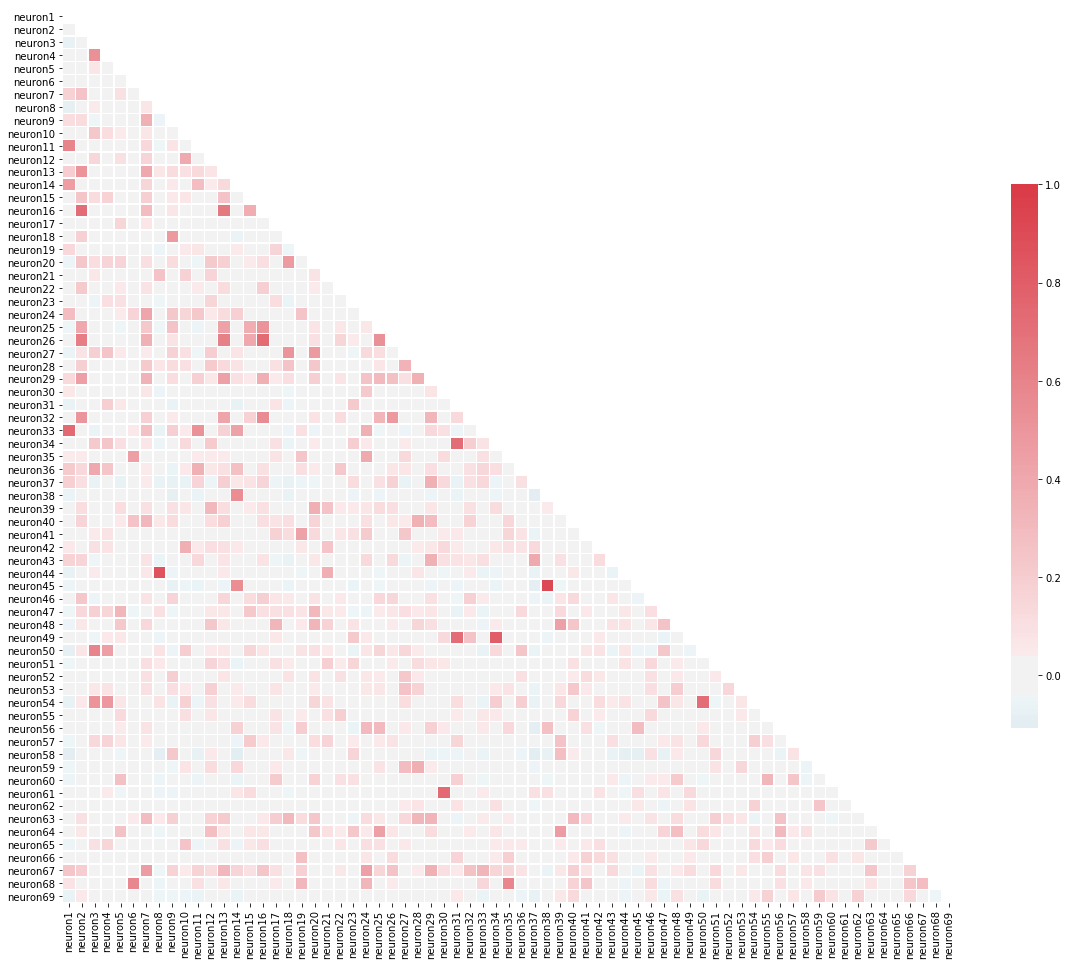

In [3]:
# Generate a mask for the upper triangle
mask = np.zeros_like(cell_transients_dataframe.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cell_transients_dataframe.corr(), mask=mask, cmap=cmap, vmax=1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Next, we assign a correlation value of interest, and we loop through our entire cell transients dataframe to find pairs of neurons that have that correlation value, or greater
>#### Finally, we print out the total amount of correlated pairs of neurons found in the cell transients dataframe for drd87

In [4]:
correlated_pairs_dict = dict()

# Find and all pairs of neurons that have a specified correlation and return a nested dictionary of them
COR_VAL = 0.3
corr_pairs_of_neurons = 0
columns = cell_transients_dataframe.columns.tolist()
for i in range(0, len(columns)):
    for j in range(i+1, len(columns)):
        r_value = np.corrcoef(cell_transients_dataframe[columns[i]], cell_transients_dataframe[columns[j]])[0][1]
        if abs(r_value) >= COR_VAL:
            corr_pairs_of_neurons += 1
            if columns[i] not in correlated_pairs_dict:
                correlated_pairs_dict[columns[i]] = {columns[j]:r_value}
            else: 
                correlated_pairs_dict[columns[i]][columns[j]] = r_value

print("There are {} correlated pairs of neurons".format(corr_pairs_of_neurons))

There are 92 correlated pairs of neurons


## According to the heatmap, neuron 38 and neuron 45 are highly correlated   
>### We use a homebrewed function to compute the correlation of neuron 38 and 45, as well as plotting them on a scotter plot
- Note that our homebrewed function, `neuron_scatter_plot_with_reg()`, returns two objects:
 - `fig` - an object that tells plotly how and what to plot on the scatter plot
 - `r_value` - the correlation coefficient of the two neurons passed into the function, `neuron_scatter_plot_with_reg()`

In [5]:
fig, r_value = au.neuron_scatter_plot_with_reg('neuron38', 'neuron45', cell_transients_dataframe)
print("Correlation(neuron38, neuron45) = {}".format(r_value))
plotly.offline.iplot(fig)
au.neuron_line_plot('neuron38', 'neuron45', cell_transients_dataframe)

Correlation(neuron38, neuron45) = 0.9199946955038318


### We create a clustermap of all the neurons in the cell transients dataframe using the centroid method, 
$$dist(s,t)= \mid\mid c_s - c_t \mid\mid_2$$
##### where $c_s$ and $c_t$ are the centroids of clusters and $s$ and $t$, respecitvely. When two clusters $s$ and $t$ are combined into a new cluster $u$ the new centroid is computed over all the original objects in clusters $s$ and $t$. The distance then becomes the Euclidean distance between the centroid of $u$ and the centroid of a remaining cluster $v$ in the forest.

##### https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

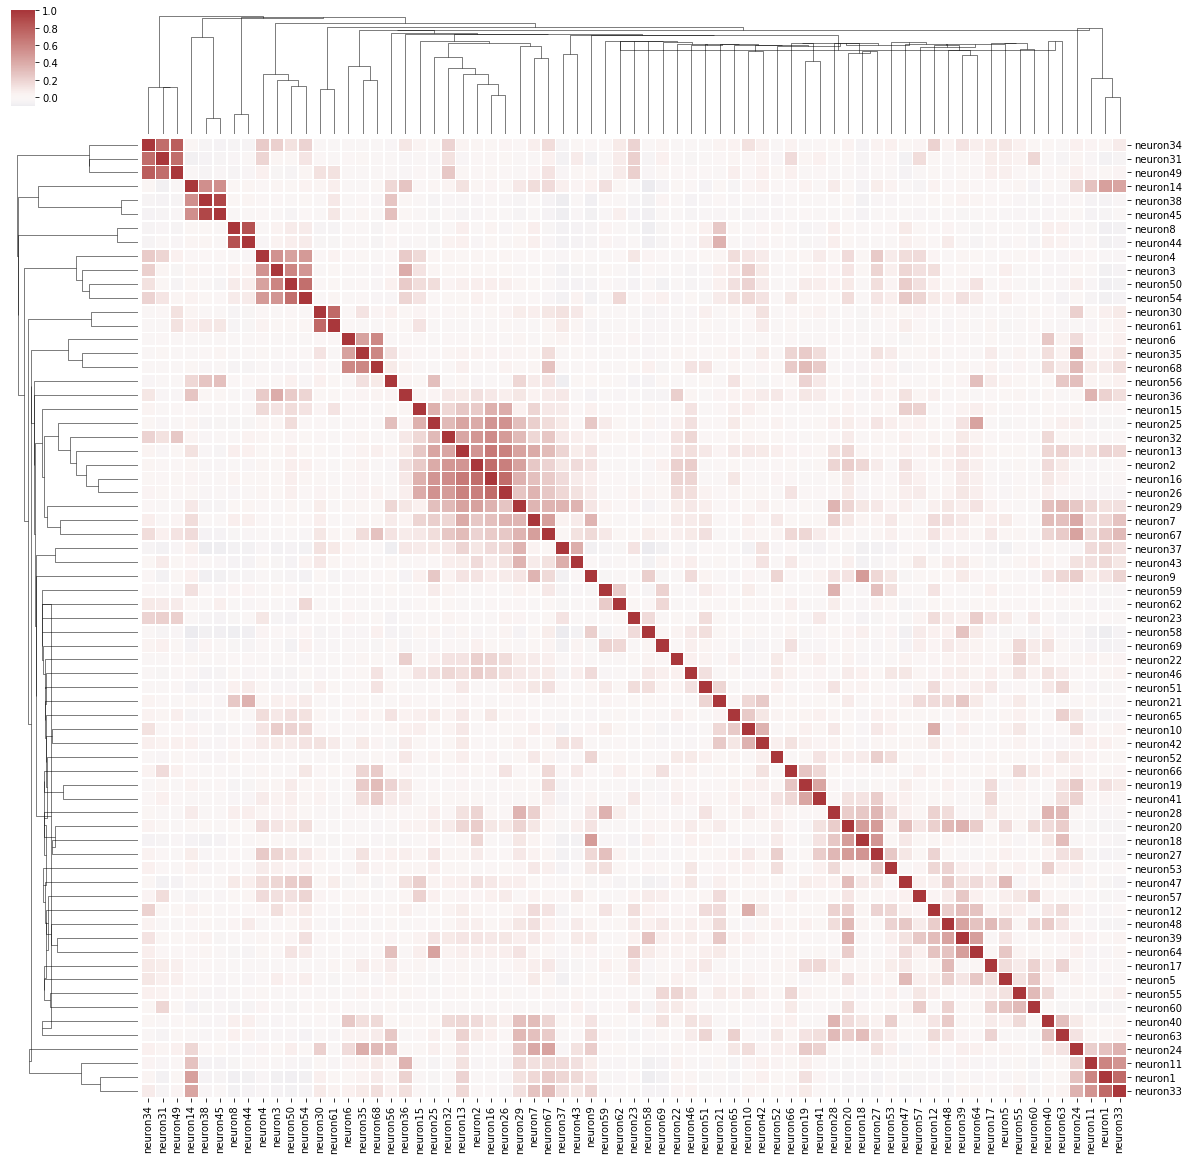

In [6]:
# TODO: Add behavior to the cluster map
sns.clustermap(cell_transients_dataframe.corr(), center=0, cmap="vlag", linewidths=.75, figsize=(20, 20), method="centroid");

## How does the relationship between two neurons change as a function of some behavior?

In [7]:
behavior_column_names = ['Trial_time', 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

activity_df = pd.read_csv('~/Hen_Lab/Mice/drd46_experiments/activity_drd46.csv', header=None)
behavior_df = pd.read_csv('/Users/saveliyyusufov/Hen_Lab/Mice/drd87_experiments/behavior_drd87.csv', header=None)

# Save only every nth row in order to downsample behavior Dataframes from 30fps -> 10fps
ROW_MULTIPLE = 3
behavior_df.drop(behavior_df.index[[i for i in range(0, len(behavior_df.index)) if i % ROW_MULTIPLE != 0]], inplace=True)

# For the activity Dataframe, we Change column names to corresponding neuron names 
activity_df.columns = ['neuron' + str(i) for i in range(1, len(activity_df.columns) + 1)]

# Change column names to the behavior column names found in the MossyEPM, MATLAB struct
behavior_df.columns = behavior_column_names

# Fix indexing after downsample
behavior_df.reset_index(drop=True, inplace=True)

# Make the behavior Dataframe indexed by Recording time
# behavior_df.set_index('Recording time', inplace=True)

# Make the behavior Dataframe and the activity Dataframe have the same amount of rows 
if len(behavior_df.index) > len(activity_df.index):
    diff = len(behavior_df.index) - len(activity_df.index)
    behavior_df = behavior_df[:-diff]
elif len(behavior_df.index) < len(activity_df.index):
    diff = len(activity_df.index) - len(behavior_df.index)
    activity_df = activity_df[:-diff]

# Define running frames
VELOCITY_CUTOFF = 4;

# Adds column to the end of the behavior Dataframe and make each cell in that column a 0 
# if the corresponding velocity < VELOCITY_CUTOFF or a 1 if the corresponding velocity >= VELOCITY_CUTOFF
behavior_df['Running_frames'] = [1 if velocity > VELOCITY_CUTOFF else 0 for velocity in behavior_df['Velocity'].tolist()]

# Calculate rates by arm, running, and time period

# Divide session into this many bins
TIME_BIN_FACTOR = 3; 

AUC_dataframe.columns = ['neuron' + str(i) for i in range(1, len(AUC_dataframe.columns)+1)]
result_dataframe = pd.concat([cell_transients_dataframe, behavior_df], axis=1)

### According to the regression model below, we predict the average flouresence level in neuron 1 and neuron 3 to be higher when drd46 was running, rather than not running

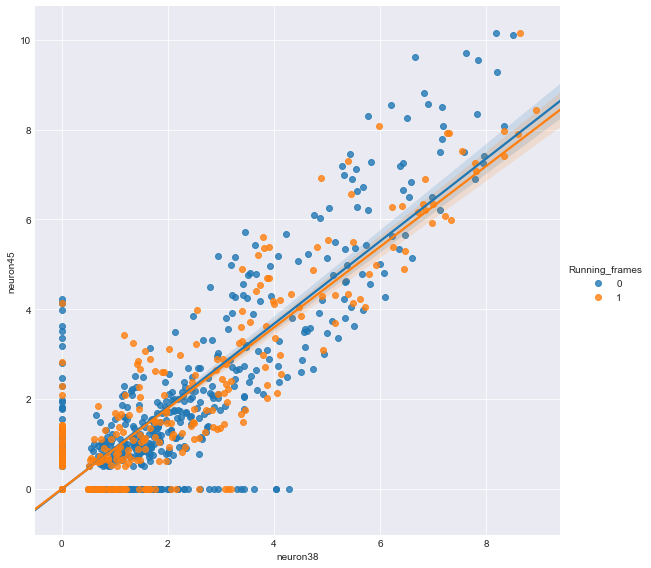

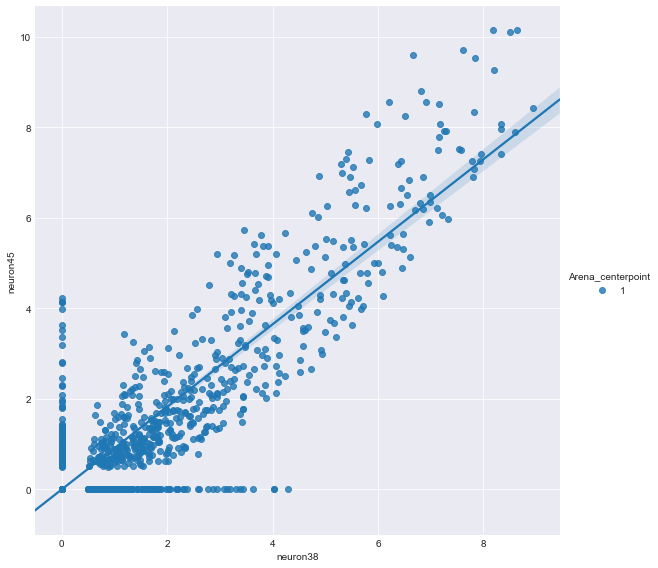

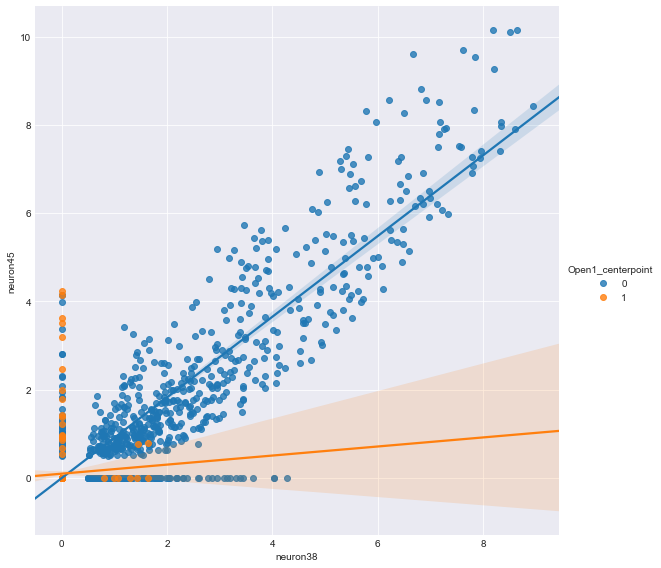

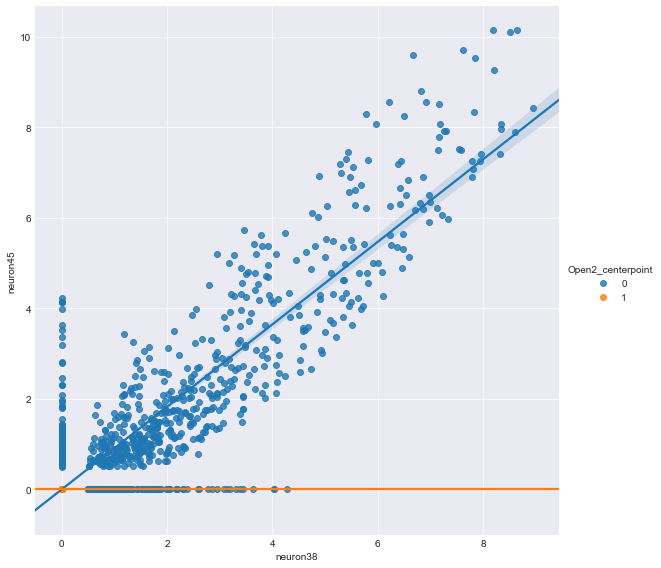

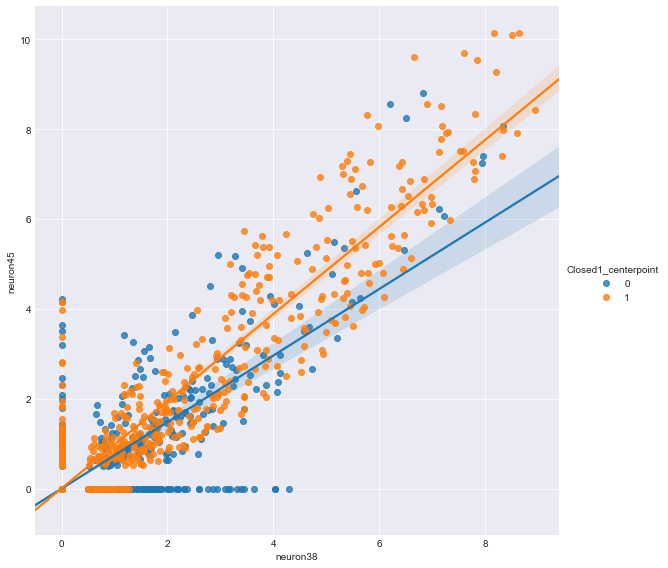

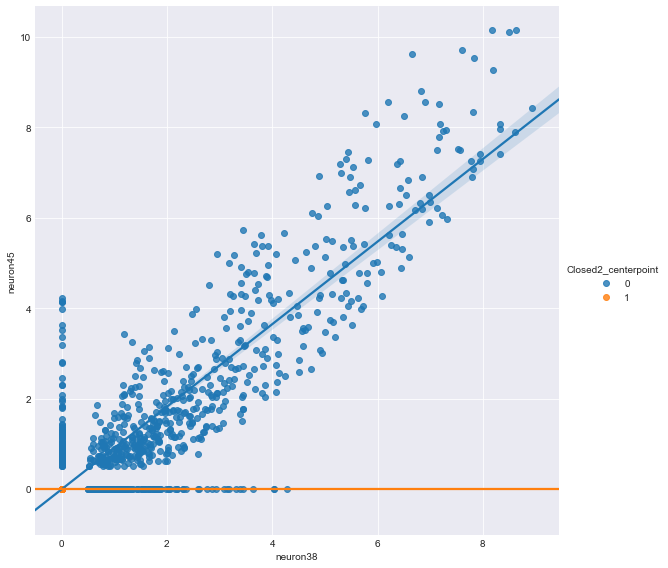

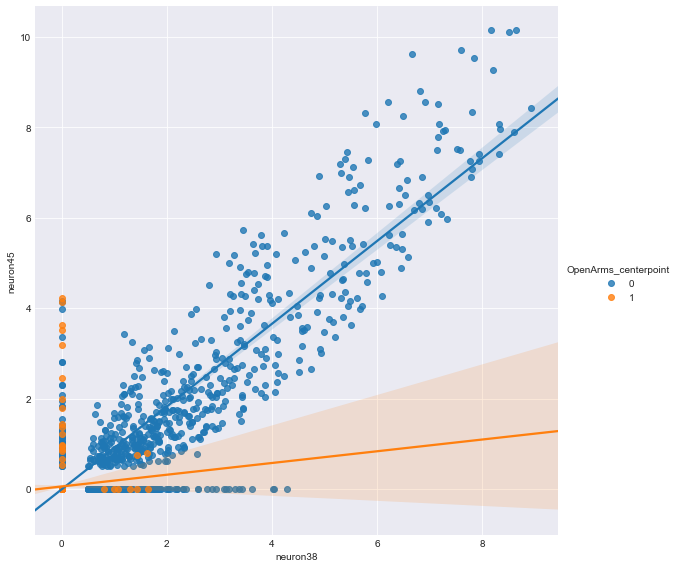

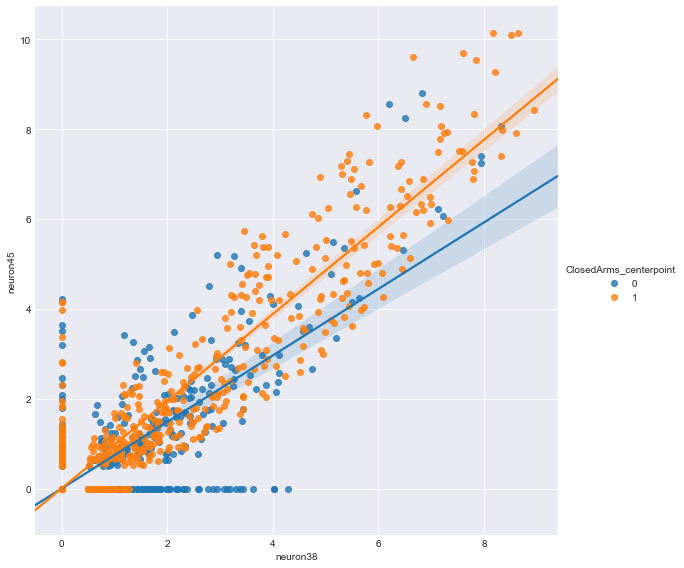

In [8]:
sns.set_style("darkgrid")

for beh in [ 'Running_frames', 'Arena_centerpoint', 'Open1_centerpoint', 'Open2_centerpoint', 'Closed1_centerpoint', 'Closed2_centerpoint', 'OpenArms_centerpoint', 'ClosedArms_centerpoint']:    
    _ = sns.lmplot(x="neuron38", y="neuron45", hue=beh, data=result_dataframe[['neuron38', 'neuron45', 'Arena_centerpoint', 'Open1_centerpoint', 'Open2_centerpoint',
        'Closed1_centerpoint', 'Closed2_centerpoint', 'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Running_frames']], size=8);

## Perhaps a better way to compute the correlation between two neurons...
$$q=\frac{|\vec{n_1} \wedge \vec{n_2}|}{|\vec{n_1} \vee \vec{n_2}|}$$

In [9]:
def q(dataframe, neuron_x, neuron_y):
    mag_of_neuron_x_and_neuron_y = len(dataframe[(dataframe[neuron_x] != 0) & (dataframe[neuron_y] != 0)])
    mag_of_neuron_x_or_neuron_y = len(dataframe[(dataframe[neuron_x] != 0) | (dataframe[neuron_y] != 0)])
    return mag_of_neuron_x_and_neuron_y / mag_of_neuron_x_or_neuron_y

In [10]:
def get_d_rate(dataframe, neuron_activity_df, behavior):
    FRAME_RATE = 10
    beh_vec = dataframe.loc[dataframe[behavior] != 0, neuron_activity_df.columns]
    no_beh_vec = dataframe.loc[dataframe[behavior] == 0, neuron_activity_df.columns]
    return FRAME_RATE * (beh_vec.sum()/len(beh_vec) - no_beh_vec.sum()/len(no_beh_vec))

In [11]:
%timeit get_d_rate(result_dataframe, cell_transients_dataframe, "Running_frames")

8.5 ms ± 524 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Create dataframe of real $d$ values for all neurons

In [12]:
def set_real_d_df(dataframe, neuron_activity_df, behavior):
    real_df = pd.DataFrame(columns=neuron_activity_df.columns, index=["d"])
    real_df.loc['d'] = get_d_rate(dataframe, neuron_activity_df, behavior)
    return real_df

In [15]:
real_d_df = set_real_d_df(result_dataframe, cell_transients_dataframe, "Running_frames")
real_d_df

,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron60,neuron61,neuron62,neuron63,neuron64,neuron65,neuron66,neuron67,neuron68,neuron69
d,0.933957,1.86404,2.11783,1.73031,1.36115,0.379142,0.97147,-0.695087,2.62016,0.9863,...,0.121947,-0.41011,0.385461,1.61037,0.983147,1.22125,0.656729,1.46233,1.67049,0.787293


## Perform a cyclic shift of all indices in the result dataframe by a random integer from $[0, |resultdataframe.index|]$

In [16]:
def shuffle(n, neuron_activity_df, mouse_behavior_df, behavior):
    """Bootstrapping function

    Bootstrapping function that allows estimation of the sampling 
    distribution using cyclical shifting of the index of a pandas dataframe.

    Args:
        n: the number of random shuffles to be performed on the given data
        neuron_activity_df: the neuron activity dataframe for a given mouse
        mouse_behavior_df: the behavior dataframe for a given mouse 
        (must directly correspond with neuron_activity_df)
        behavior: the behavior to be estimated

    Returns:
        A Pandas DataFrame that contains all the neuron and behavior
        data after all the data has been bootstraped
    """ 
    shifted_beh_df = behavior_df.copy()
    shuffled_df = pd.DataFrame(columns=neuron_activity_df.columns, index=range(1, n+1))
    for shuffle_num in range(1, n+1):
        shifted_beh_df.set_index(np.roll(behavior_df.index, random.randrange(1, len(behavior_df.index))), inplace=True)
        shifted_df = pd.concat([neuron_activity_df, shifted_beh_df], axis=1)
        shuffled_df.loc[shuffle_num] = get_d_rate(shifted_df, neuron_activity_df, behavior)

    return shuffled_df

In [21]:
bootstrapped = shuffle(1000, cell_transients_dataframe, behavior_df, 'Running_frames')

In [78]:
def confidence_plot(bootstrapped_df, real_d_df, neuron):
    _ = sns.distplot(bootstrapped[neuron].tolist(), fit=stats.norm);
    print("standard dev of {} = {}, real d value of {} = {}".format(neuron, bootstrapped[neuron].std(), neuron, real_d_df[neuron]['d']))

standard dev of neuron1 = 0.8660632930124987, real d value of neuron1 = 0.9339567660361131


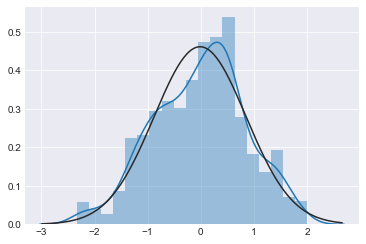

In [79]:
confidence_plot(bootstrapped, real_d_df, "neuron1")